# Part 2 - Validation on testes peptides

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted


import pickle
import joblib

import joblib
from sklearn.decomposition import PCA
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
# This function wil convert the undefined MIC values to 100.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        mic_value = float(mic_value.replace('>', ''))
        v = 100
        return v
    else:
        return float(mic_value)

In [19]:
# load meta_data with mutations on PG1
meta_data = pd.read_excel('data/pg1_muts_validation_set_v01.2.xlsx')
meta_data

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174
5,PG1_3mut_1210489,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,<-0.25,16,0.735867,1.070920
6,PG1_3mut_1536372,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,<-0.25,2,0.906433,0.258366
7,PG1_3mut_1147726,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,<-0.25,16,0.043860,-0.153815
8,PG1_3mut_1980555,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,<-0.25,32,0.116959,0.573184
9,PG1_3mut_1658870,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,<-0.25,64,0.092593,0.772756


## Load embeddings

In [20]:
######################## Load the embedding ######################
dir_path = 'data/embedding/esm2_15B_PG1_validation/'
embeddings = {}
for file in os.listdir(dir_path):
        file_path = str(dir_path) + file 
        label = file.split('.pt')[0]
        embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID2', right_index=True)


features = data.iloc[:,meta_data.shape[1]:]
features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.109975,-0.134590,-0.111443,0.218644,-0.237748,0.131493,-0.119502,0.234007,-0.042554,0.338132,-0.181911,-0.070123,0.285914,0.132456,0.145206,-0.119641,0.016052,-0.160409,0.175323,0.006981,0.031700,0.035921,-0.388611,0.106619,-0.263324,0.010144,0.089600,-0.232413,0.044148,0.205849,-0.088589,-0.051135,-0.249299,-0.100425,-0.034155,-0.042539,0.145001,-0.053556,0.325825,0.009630,0.188548,-0.276242,0.057267,0.159372,-0.074977,0.383486,-0.059249,0.067180,-0.192458,-0.160447,...,-0.287571,-0.199986,0.265588,-0.087591,-0.035537,0.052414,-0.032724,0.074804,0.253470,0.188196,0.000840,-0.048806,0.006446,0.150435,0.038589,0.085381,-0.230726,0.268536,-0.116890,-0.014526,-0.264989,-0.072022,-0.083098,-0.169087,0.285792,0.045038,0.190472,-0.006061,0.086329,-0.000662,0.091908,0.035746,-0.148846,-0.118648,-0.209491,-0.021450,-0.027162,-0.213849,-0.050013,0.006487,-0.136047,-0.087660,0.107472,-0.270478,0.122341,-0.089307,0.137297,0.075365,-0.198461,-0.035045
1,0.129701,-0.184889,-0.115536,0.161651,-0.224050,0.112427,-0.157890,0.269912,-0.049523,0.307800,-0.149578,-0.081749,0.265789,0.177847,0.169391,-0.094384,0.128813,-0.176698,0.105074,0.014042,0.026007,0.069966,-0.333289,0.142775,-0.248938,-0.029828,0.020388,-0.144963,0.050747,0.161994,-0.136832,-0.064507,-0.254568,-0.029669,-0.057159,0.031107,0.171488,-0.025439,0.370129,-0.041123,0.135727,-0.279007,0.066811,0.166149,-0.087821,0.364228,-0.020949,0.117404,-0.246447,-0.102719,...,-0.252198,-0.117499,0.283669,-0.081878,-0.082878,0.056859,-0.002050,0.037367,0.262278,0.109654,0.026107,0.013662,0.029625,0.179096,0.087634,0.068997,-0.194529,0.256631,-0.086368,0.013377,-0.315640,-0.012413,-0.098380,-0.130370,0.274497,0.049318,0.221853,-0.059104,0.077843,-0.038710,0.128514,0.042598,-0.170303,-0.052412,-0.178424,-0.050331,-0.044874,-0.277650,0.018790,-0.008888,-0.106790,-0.129787,0.076798,-0.208119,0.098149,-0.133004,0.089372,0.093026,-0.170869,-0.013929
2,0.099468,-0.114953,-0.117187,0.183187,-0.209792,0.091260,-0.130392,0.256235,-0.053187,0.229403,-0.153716,-0.110329,0.224579,0.217258,0.185253,-0.137833,0.123428,-0.071266,0.113991,-0.005573,0.083241,0.095849,-0.291120,0.084410,-0.293609,-0.046842,0.064312,-0.096830,0.032436,0.084759,-0.103322,-0.039152,-0.284039,-0.067096,-0.115826,0.051603,0.165042,-0.094658,0.376194,-0.128548,0.181254,-0.249639,0.065785,0.160171,-0.091013,0.350580,0.005549,0.078152,-0.205696,-0.069624,...,-0.265148,-0.125474,0.232081,-0.136144,-0.026184,0.075733,0.041864,0.058491,0.310277,0.156786,-0.067325,0.029883,0.027132,0.108766,0.068593,-0.053529,-0.139792,0.200807,-0.150195,0.036576,-0.200391,-0.061608,-0.052911,-0.173216,0.241643,0.071768,0.181315,-0.034740,0.006019,-0.071225,0.139590,0.150875,-0.073768,-0.083165,-0.124568,-0.063161,-0.023962,-0.257893,0.000161,0.006935,-0.195330,-0.116773,0.137988,-0.164647,0.119364,-0.178338,0.031593,0.029154,-0.215111,-0.017543
3,0.156776,-0.105166,-0.063266,0.204592,-0.202521,0.076685,-0.140390,0.251750,-0.082083,0.299491,-0.138542,-0.093754,0.238516,0.210513,0.224224,-0.099772,0.084619,-0.138276,0.065005,0.034831,0.028210,0.085703,-0.210246,0.129641,-0.316469,-0.079329,0.070912,-0.132105,-0.009244,0.151050,-0.079498,-0.048807,-0.207856,-0.036181,-0.060802,0.062600,0.129042,-0.139074,0.310381,-0.097736,0.152451,-0.305469,0.069221,0.137120,-0.135764,0.433612,-0.017008,0.039403,-0.203412,-0.054635,...,-0.269408,-0.143549,0.283143,-0.004776,-0.062685,0.133809,0.033932,0.047367,0.329623,0.135072,-0.037661,0.074512,0.027695,0.104189,0.026622,0.066428,-0.113747,0.263858,-0.121201,0.010072,-0.256017,-0.060592,-0.097629,-0.164075,0.268416,-0.001478,0.174

# Predictions on Validation set witn models v01 - feature selection with correlation

## Hemolysis 

In [21]:
# Load the model
model = joblib.load('models/model_v01.2_Lasso_esm2_15B_Hemolysis_regression_corr06.pkl')

# load the list from the file
with open('models/correlated_columns_v01.2_esm2_15B_hemolysis_corr06.pkl', 'rb') as f:
    corr_columns = pickle.load(f)

In [22]:
# calculates the the hemolysis score
pred = model.predict(features[corr_columns])


sum(pred <= 2)

36

In [23]:
meta_data['hemolysis_pred_v01.2'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714


## Selectivity

In [24]:
# Load the model
model = joblib.load('models/model_v01.2_SVR_esm2_15B_selectivity_regression_corr065.pkl')

#load the list from the file
with open('models/correlated_columns_v01.2_esm2_15B_selectivity_corr065.pkl', 'rb') as f:
    correlated_columns = pickle.load(f)

In [25]:
# calculates the the hemolysis score
pred = model.predict(features[correlated_columns])
sum(pred < 0.5)

32

In [26]:
meta_data['selectivity_pred_v01.2'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956


## Activity

In [27]:
# save the model
model = joblib.load('models/model_v01.2_GNB_esm2_15B_activity_classification_corr03.pkl')

#load the list from the file
with open('models/correlated_columns_v01.2_esm2_15B_activity_corr03.pkl', 'rb') as f:
    correlated_columns = pickle.load(f)

In [28]:
# calculates the probability of being active
prob = model.predict_proba(features[correlated_columns])
pred = (prob[:, 1] * 100).round(2)

sum(pred == 100)

36

In [29]:
meta_data['activity_pred_v01.2'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,activity_pred_v01.2
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,100.0
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,100.0
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,100.0
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,100.0
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,100.0


# Predictions on Validation set witn models v02 - feature selection with PCAs

## Hemolysis

In [33]:
# Loading the model
model = joblib.load('models/model_v02_Lasso30_esm2_15B_hemolysis_regression.pkl')

# Loading PCA weights
pca = joblib.load('models/weights_pca30_v02_esm2_15B_hemolysis.pkl')

In [34]:
# calculates the probability of being active
pred = model.predict(pca.transform(features))

sum(pred <=2)

31

In [35]:
meta_data['hemolysis_pred_v02'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,activity_pred_v01.2,hemolysis_pred_v02
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,100.0,-4.054558
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,100.0,-6.763184
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,100.0,-8.310135
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,100.0,-2.867607
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,100.0,-3.139629


## Selectivity

In [37]:
# Loading the model
model = joblib.load('models/model_v02_svmR20_esm2_15B_selectivity_regression.pkl')

# Loading PCA weights
pca = joblib.load('models/weights_pca20_v02_esm2_15B_selectivity.pkl')

In [38]:
# calculates the probability of being active
pred = model.predict(pca.transform(features))

sum(pred < 0.5)

6

In [39]:
meta_data['selectivity_pred_v02'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,activity_pred_v01.2,hemolysis_pred_v02,selectivity_pred_v02
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,100.0,-4.054558,0.448899
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,100.0,-6.763184,0.368799
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,100.0,-8.310135,0.390410
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,100.0,-2.867607,0.552553
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,100.0,-3.139629,0.636513


## Activity

In [40]:
# Loading the model
model = joblib.load('models/model_v02_GNB15_esm2_15B_activity_classification.pkl')

# Loading PCA weights
pca = joblib.load('models/weights_pca15_v02_esm2_15B_activity.pkl')

In [41]:
# calculates the probability of being active
prob = model.predict_proba(pca.transform(features))
pred = (prob[:, 1] * 100).round(2)

sum(pred > 90)

21

In [42]:
meta_data['activity_pred_v02'] = pred
meta_data.head()

,ID,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,group,MIC MH,%hemo,L10Select,hemolysis_pred_v01.2,selectivity_pred_v01.2,activity_pred_v01.2,hemolysis_pred_v02,selectivity_pred_v02,activity_pred_v02
0,PG1_3mut_1739000,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,<-0.25,16,0.428850,0.836425,-7.675692,-0.987362,100.0,-4.054558,0.448899,92.34
1,PG1_3mut_1218602,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,<-0.25,4,0.341131,0.134981,-14.298704,-1.215473,100.0,-6.763184,0.368799,88.34
2,PG1_3mut_1896424,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,CP,>64,-0.165692,NaN,-14.385390,-1.305665,100.0,-8.310135,0.390410,95.37
3,PG1_3mut_1275003,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,<-0.25,64,0.165692,1.025482,-19.078636,-0.686002,100.0,-2.867607,0.552553,90.87
4,PG1_3mut_257802,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,<-0.25,8,0.721248,0.761174,-3.053714,-0.247956,100.0,-3.139629,0.636513,94.94


# Overall Performance V1 x V2

In [43]:
meta_data['MIC'] = [convert_mic(x) for x in meta_data['MIC MH']]
meta_data['L10Select'].fillna(100, inplace=True)

In [45]:
# true values
true_act = [1 if x<=8 else 0 for x in meta_data['MIC']]
true_hemo = [1 if x<=2 else 0 for x in meta_data['%hemo']]
true_sel = [1 if x<0.5 else 0 for x in meta_data['L10Select']]

pred_v01_act = [1 if x<=8 else 0 for x in meta_data['activity_pred_v01.2']]
pred_v01_hemo = [1 if x<=2 else 0 for x in meta_data['hemolysis_pred_v01.2']]
pred_v01_sel = [1 if x<0.5 else 0 for x in meta_data['selectivity_pred_v01.2']]

pred_v02_act = [1 if x<=8 else 0 for x in meta_data['activity_pred_v02']]
pred_v02_hemo = [1 if x<=2 else 0 for x in meta_data['hemolysis_pred_v02']]
pred_v02_sel = [1 if x<0.5 else 0 for x in meta_data['selectivity_pred_v02']]

In [46]:
df = pd.DataFrame()

# version 1
accuracy = metrics.accuracy_score(true_act, pred_v01_act)
recall = metrics.recall_score(true_act, pred_v01_act)
precision = metrics.precision_score(true_act, pred_v01_act)
f1_score = metrics.f1_score(true_act, pred_v01_act)

df_dict={'Version': 'V01', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 1
accuracy = metrics.accuracy_score(true_hemo, pred_v01_hemo)
recall = metrics.recall_score(true_hemo, pred_v01_hemo)
precision = metrics.precision_score(true_hemo, pred_v01_hemo)
f1_score = metrics.f1_score(true_hemo, pred_v01_hemo)

df_dict={'Version': 'V01', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 1
accuracy = metrics.accuracy_score(true_sel, pred_v01_sel)
recall = metrics.recall_score(true_sel, pred_v01_sel)
precision = metrics.precision_score(true_sel, pred_v01_sel)
f1_score = metrics.f1_score(true_sel, pred_v01_sel)

df_dict={'Version': 'V01', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

df

/stor/work/Wilke/luiz/DMS_ML_AMP/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Activity,0.750000,0.000000,0.000000,0.000000
0,V01,Hemolysis,0.888889,1.000000,0.888889,0.941176
0,V01,Selectivity,0.222222,0.833333,0.156250,0.263158


In [47]:
# version 2
accuracy = metrics.accuracy_score(true_act, pred_v02_act)
recall = metrics.recall_score(true_act, pred_v02_act)
precision = metrics.precision_score(true_act, pred_v02_act)
f1_score = metrics.f1_score(true_act, pred_v02_act)

df_dict={'Version': 'V02', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 2
accuracy = metrics.accuracy_score(true_hemo, pred_v02_hemo)
recall = metrics.recall_score(true_hemo, pred_v02_hemo)
precision = metrics.precision_score(true_hemo, pred_v02_hemo)
f1_score = metrics.f1_score(true_hemo, pred_v02_hemo)

df_dict={'Version': 'V02', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

# version 2
accuracy = metrics.accuracy_score(true_sel, pred_v02_sel)
recall = metrics.recall_score(true_sel, pred_v02_sel)
precision = metrics.precision_score(true_sel, pred_v02_sel)
f1_score = metrics.f1_score(true_sel, pred_v02_sel)

df_dict={'Version': 'V02', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])

df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Activity,0.750000,0.000000,0.000000,0.000000
0,V01,Hemolysis,0.888889,1.000000,0.888889,0.941176
0,V01,Selectivity,0.222222,0.833333,0.156250,0.263158
0,V02,Activity,0.750000,0.111111,0.500000,0.181818
0,V02,Hemolysis,0.861111,0.906250,0.935484,0.920635
0,V02,Selectivity,0.777778,0.333333,0.333333,0.333333


In [48]:
# id_vars: Columns that should remain unaltered.
# value_vars: Columns that you want to melt (i.e., unpivot). These columns will be transformed from wide format to long format.
# var_name: Name of the new column that will store the melted columns' names (default is 'variable').
# value_name: Name of the new column that will store the values (default is 'value').

df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.750000
1,V01,Activity,F1 Score,0.000000
2,V01,Activity,Precision,0.000000
3,V01,Activity,Recall,0.000000
4,V01,Hemolysis,Accuracy,0.888889
5,V01,Hemolysis,F1 Score,0.941176
6,V01,Hemolysis,Precision,0.888889
7,V01,Hemolysis,Recall,1.000000
8,V01,Selectivity,Accuracy,0.222222
9,V01,Selectivity,F1 Score,0.263158


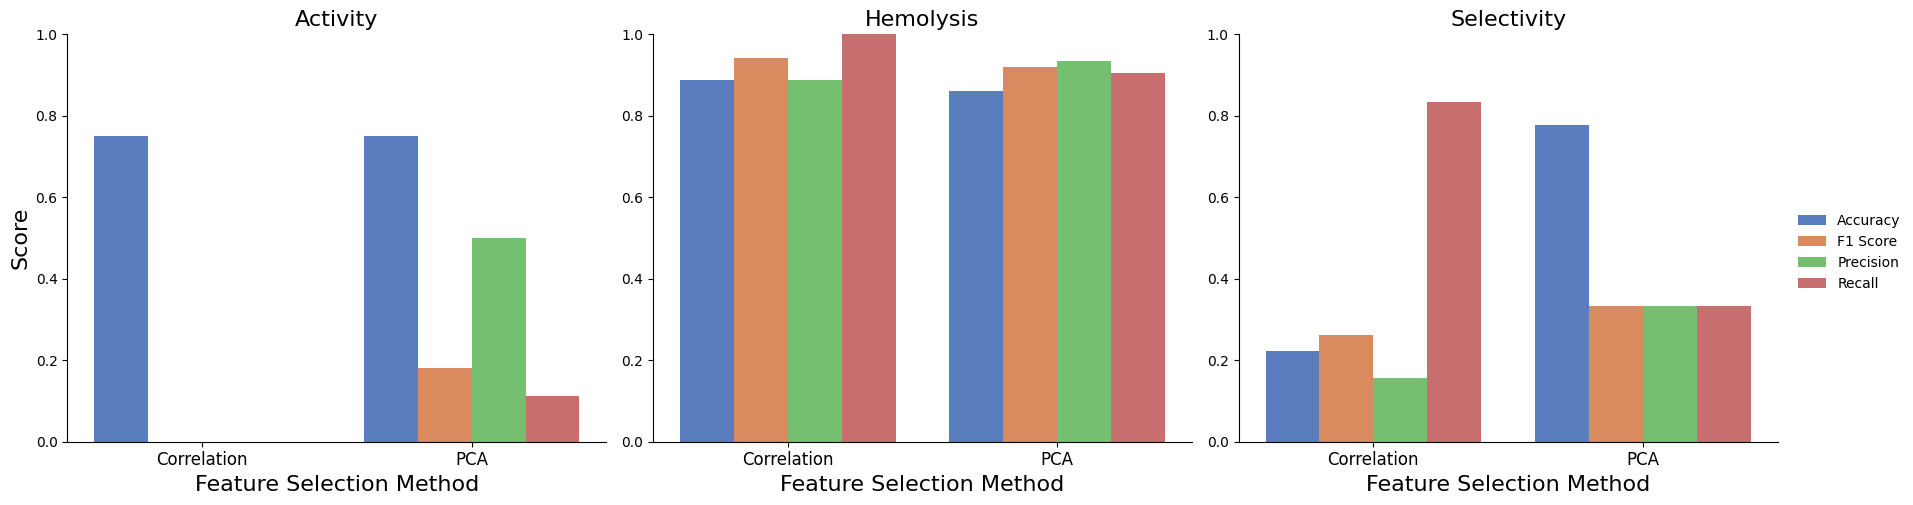

In [50]:
g = sns.FacetGrid(df_melted, col="Feature", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Version", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Feature Selection Method", "Score", size=16)


axes = g.axes.flatten()
axes[0].set_title("Activity", size=16)
axes[1].set_title("Hemolysis", size=16)
axes[2].set_title("Selectivity", size=16)

tick_labels = ['Correlation', 'PCA']
for ax in axes: 
    ax.set_xticks(range(len(tick_labels)))  # Set x-tick positions
    ax.set_xticklabels(tick_labels, size=12) 


g.add_legend()
#plt.savefig('results/model_v01.2-2_performance.png', dpi=1200)
plt.show()